# $k$-Means


$k$-Means (ou $k$-Médias) é provavelmente o algoritmo não-supervisionado mais simples para tarefas de agrupamento. Isso porque seu conceito de agrupamento ótimo pode ser definido como:

- O "centro do agrupamento" é a média aritmética de todos os pontos do agrupamento.
- Cada ponto deve ficar mais próximo do centro de seu próprio agrupamento do que do centro de outros agrupamentos.

Essas 2 suposições são a base de um modelo $k$-Means. Vejamos na prática como funciona:

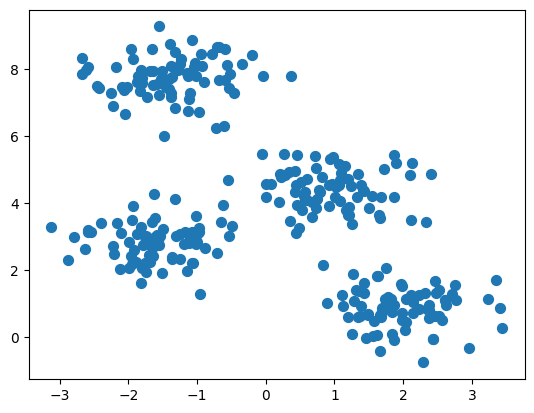

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.show()

Note que, por ser um algoritmo não supervisionado, não utilizaremos os rótulos.

Fica relativamente fácil encontrar 4 agrupamentos só de olhar. Podemos utilizar a implementação do $k$-Means no Scikit-learn para fazer encontrar esses agrupamentos de forma automática.

In [2]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Vamos visualizar os resultados plotando os dados com cores representando cada agrupamento. Vamos também plotar os centros que o $k$-Means encontrou:

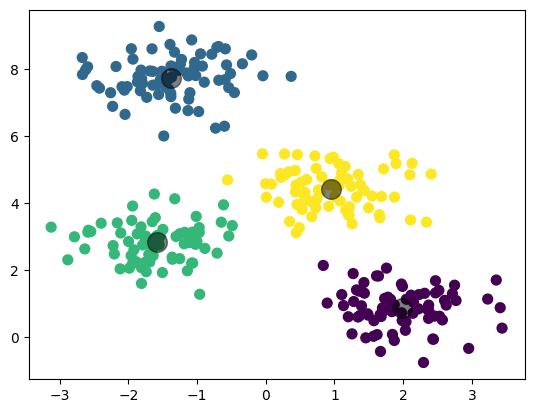

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

O $k$-Means atribui (pelo menos em casos simples) os pontos centrais de cada agrupamento de forma similar a como fariamos a olho. Vamos ver como o $k$-Means consegue encontrar estes centros de forma simples e rápida usando a técnica de Maximização das Expectativas ( _Expectation–Maximization (EM)_).


## Algoritmo do k-Means: Expectation–Maximization


Expectation–maximization é um algoritmo poderoso que aparece em vários contextos em ciência de dados. $k$-Means é um caso particular do algoritmo, que pode ser descrito da seguinte forma:


1. Chute alguns valores aleatórios como centro dos agrupamentos
2. Repita até convergir

    2.1. E-Step: atribui os pontos mais próximos de cada centro ao seu agrupamento
    
    2.2. M-Step: ajusta o centro do agrupamento para a sua média
 
Aqui o "E-step" ou passo da expectativa é chamado assim porque envolve a atualização de nossas expectativas de qual agrupamento cada ponto pertence. O "M-step" ou passo da maximização recebe esse nome porque envolve a maximização de alguma função de otimização que define a localização dos centros dos agrupamentos. Essa maximização é feita apenas tirando a média de cada agrupamento.

Resumindo, em cirunstâncias normais, cada repetição dos passos "E" e "M" vai resultar em uma estimativa melhor das características dos agrupamentos.

Podemos visualizar o algoritmo na figura a seguir. Para a inicialização mostrada aqui, o agrupamento converge após 3 iterações apenas.

<img src="assets/expectation-maximization.png" width="900"/>

O $k$-Means é tão simples que podemos escrevê-lo apenas com algumas linhas de código:

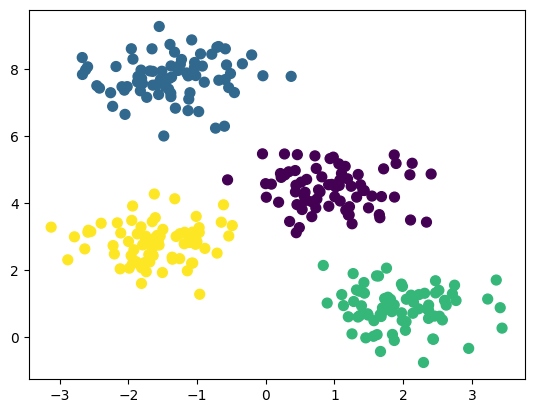

In [4]:
from sklearn.metrics import pairwise_distances_argmin
import numpy as np

def find_clusters(X, n_clusters, rseed=2):
    # 1. Escolhe os centros de forma aleatória
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Atribui o rótulo de cada amostra com o indice do centro mais próximo
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Encontra novos centros a partir da média dos pontos
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Verifica a convergência
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')
plt.show()


## Ressalvas do EM

Há alguns problemas que devem ser considerados quando usando o algoritmo EM.

### O ótimo global pode não ser encontrado

Primeiramente, apesar do EM garantir melhorar os resultados a cada passo, não há garantias de que isso irá levar à melhor solução global. Se, por exemplo, usarmos uma inicialização aleatória diferente dos centros, essa inicialização pode levar a resultados ruins:

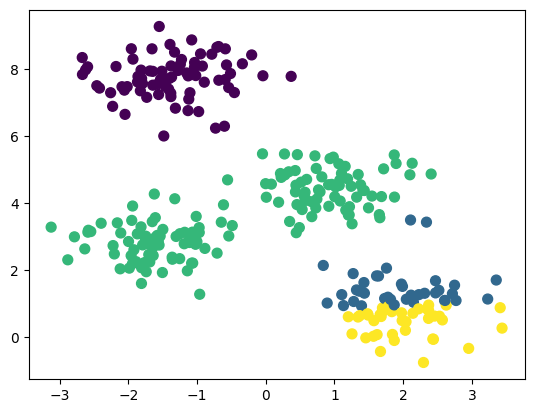

In [5]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')

plt.show()

Aqui o EM convergiu, mas não para um ótimo global. Por isso, é comum rodar o algoritmo utilizando diversas configurações de inicialização (o que o scikit-learn faz por padrão pelo parâmetro `n_init_parameter`, que tem o valor de 10 como padrão).

### O número de agrupamentos deve ser selecionado de antemão

Outro desafio comum com o $k$-means é que você precisa saber o número de agrupamentos de antemão: ele não consegue aprender o número de agrupamentos a partir dos dados. Em outras palavras, se dissermos que o problema deve ser resolvido com 6 agrupamentos, ele vai retornar 6 agrupamentos.

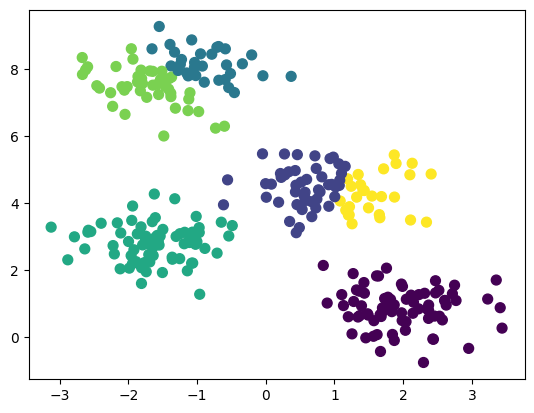

In [6]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')

plt.show()

Se o resultado faz sentido é uma pergunta dificil de responder, e depende de outras abordagens de avaliação de agrupamentos, como análise de silhueta.

### $k$-Means é limitado a bordas lineares dos agrupamentos

A suposição fundamental de $k$-means (pontos ficarão mais próximos do centro de seus agrupamentos do que de outros) significa que frequentemente o algoritmo será ineficiente se o agrupamento tiver uma geometria complexa.

Em particular, os limites entre os agrupamentos do $k$-means sempre serão lineares, o que significa que ele falha para bordas mais complexas.

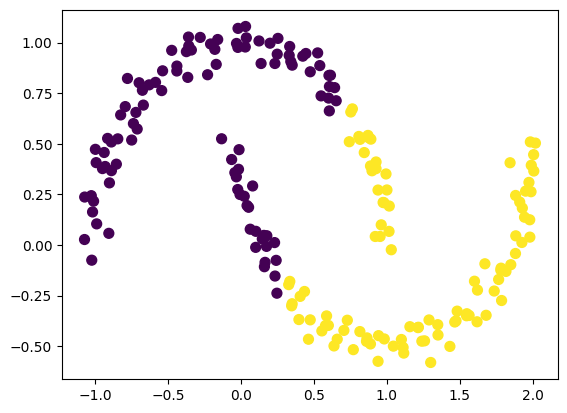

In [7]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')
plt.show()

Essa discussão lembra o problema dos kernels do SVM, que aumenta a dimensionalidade para um espaço onde os dados são linearmente separáveis. Podemos usar uma versão "kernelizada" do $k$-Means com o estimador `SpectralClustering`, que usa o grafo dos vizinhos mais próximos para computar representações em dimensionalidades mais altas dos dados, e executa o $k$-means para atribuir os rótulos.

c:\Users\mateu\Documentos\deep2\lib\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


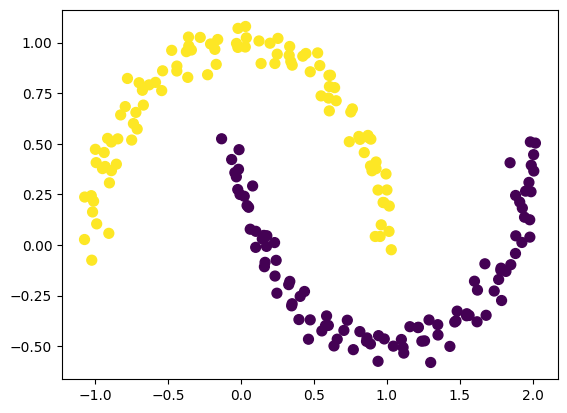

In [8]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')
plt.show()            

Com essa transformação, um $k$-Means "kernelizado" foi capaz de encontrar as bordas não lineares entre as classes.

### $k$-Means pode ficar lento para um número grande de amostras

Uma vez que cada iteração do $k$-Means deve computar a distância de todos os pontos, o algoritmo pode ficar muito lento quando o número de amostras cresce muito. Para resolver esse problema, pode-se usar a ideia de $k$-Means baseado em _batches_, em que apenas parte dos dados são apresentados por iteração. A ideia é implementada em `sklearn.cluster.MiniBatchKMeans`, e tem a mesma inferface do KMeans padrão.

### Exemplo: $k$-Means com batches para compressão de cores

Uma aplicação interessante para tarefas de agrupamento é compressão de cores em imagens. Imagine, por exemplo, uma imagem com milhões de cores. Na maioria das vezes, um grande número de cores são inúteis, e muitos pixels na imagem apresentam cores similares ou identicas. Vejamos um exemplo:

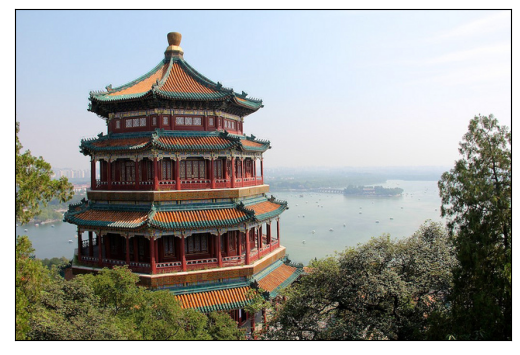

In [9]:
# Nota: requer o pacote ``pillow` instalado
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china)
plt.show()

A imagem é armazenada em um array tridimensional de tamanho (altura, largura, RGB), contendo contribuições vermelho/azul/verde como inteiros entre 0 e 255:


In [10]:
china.shape

(427, 640, 3)

Podemos visualizar esses dados como uma nuvem de pontos utilizando um espaço tridimensional representado por cores. Vamos mudar as dimensões da imagem para [n_amostras x n_características], e mudar a escala das cores entre 0 e 1.

In [11]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

visualizando essa nuvem de pontos (sobre 10000 amostras para ser mais eficiente)

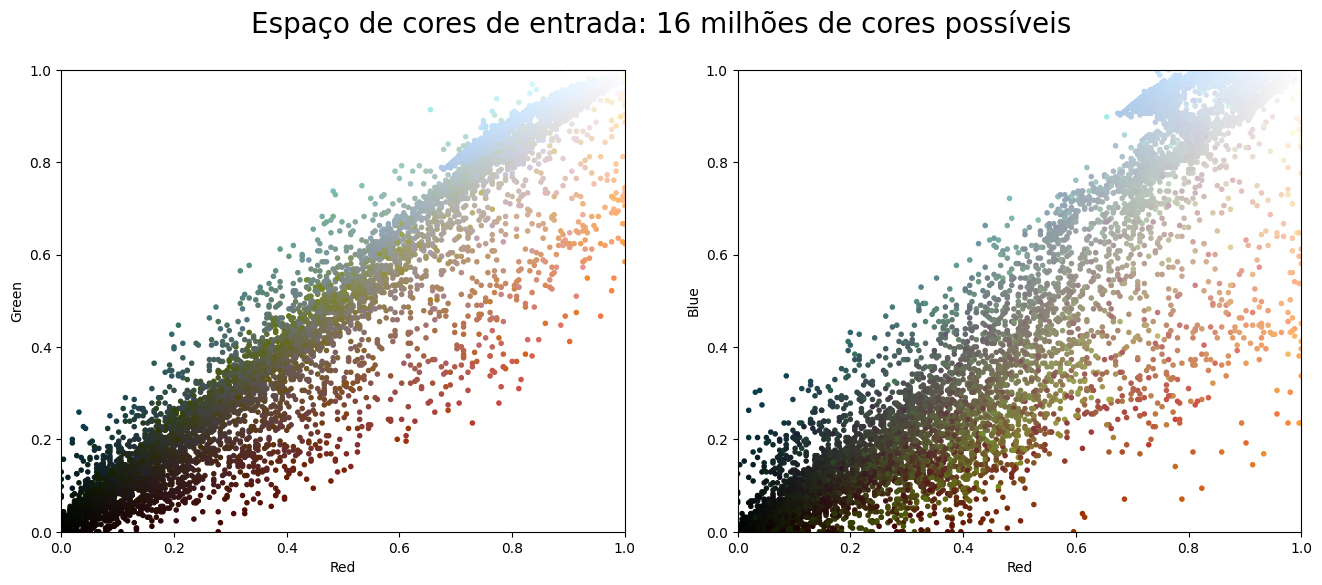

In [12]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # esolhe um subconjunto aleatório
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20)
    plt.show()
    
plot_pixels(data, title='Espaço de cores de entrada: 16 milhões de cores possíveis')

Agora vamos reduzir esses 16 milhões de cores a 16 cores usando $k$-Means. Como estamos lidando com um dataset muito grande, vamos usar o mini batch k-means, para executar o procedimento em um subconjunto dos dados por iteração, se tornando muito mais rápido.

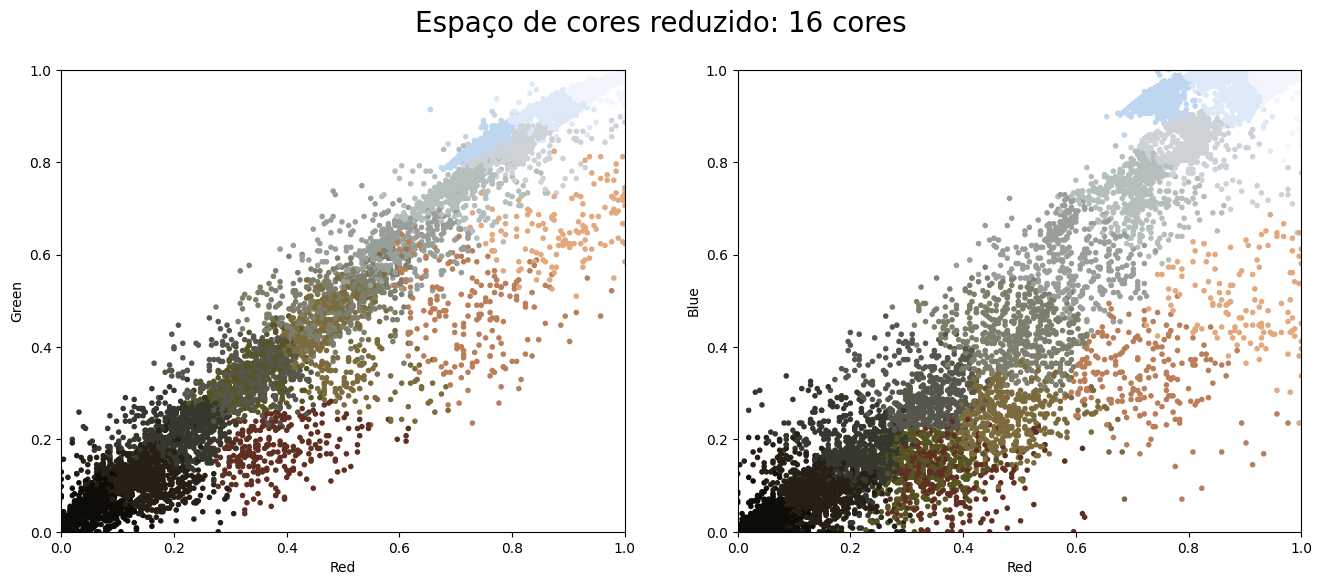

In [13]:
import warnings; warnings.simplefilter('ignore')  # para não mostrar avisos

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Espaço de cores reduzido: 16 cores")
plt.show()            

O resultado é uma imagem re-colorida, onde cada pixel é atribuido à cor do centro do agrupamento mais próximo. Plotando a imagem novamente temos o seguinte efeito:

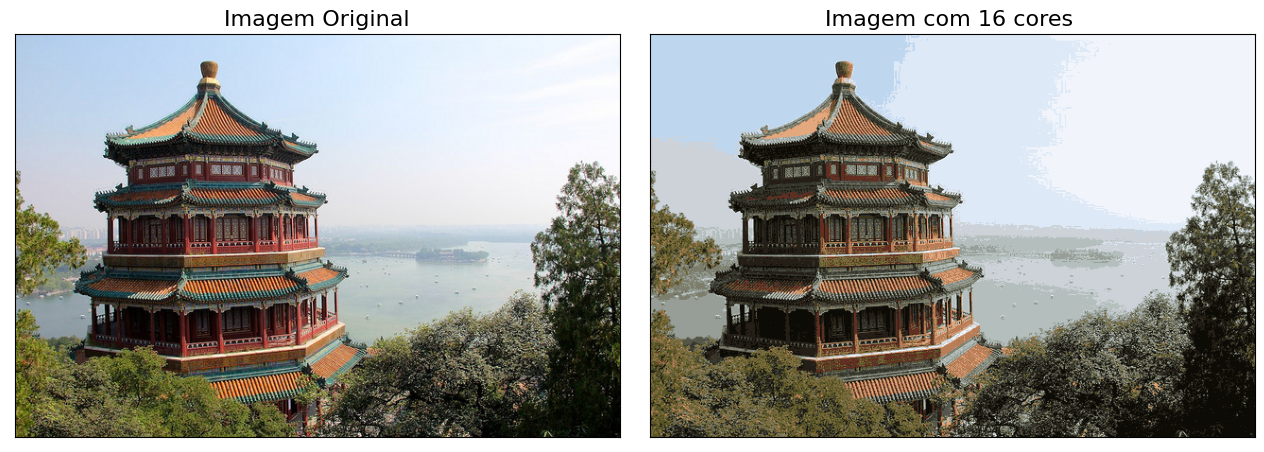

In [14]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Imagem Original', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('Imagem com 16 cores ', size=16);

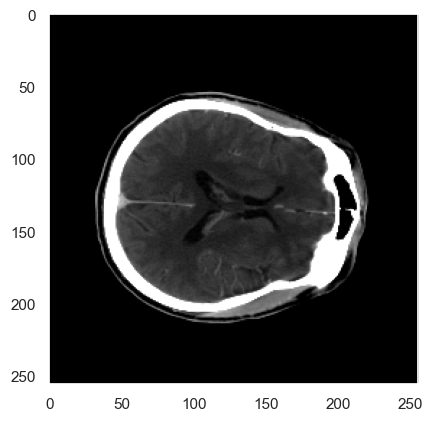

In [116]:
data = plt.imread('./assets/ct_18.png')[:,:,0]
plt.imshow(data, 'gray')
plt.grid(False);

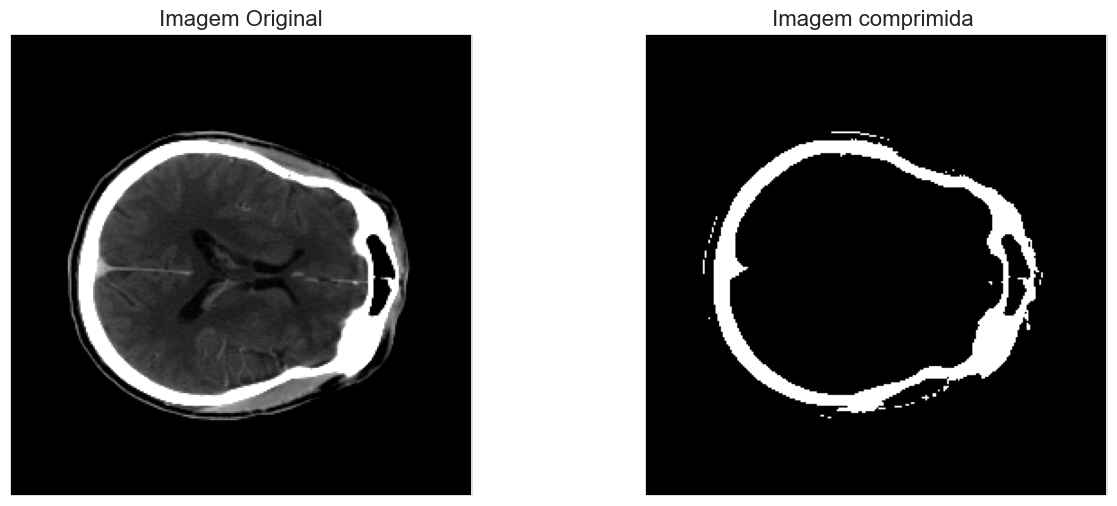

In [117]:
kmeans = MiniBatchKMeans(n_clusters=2)
kmeans.fit(data.reshape(-1,1))
new_colors = kmeans.cluster_centers_[kmeans.predict(data.reshape(-1,1))]

ct_recolored = new_colors.reshape(data.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(data, 'gray')
ax[0].set_title('Imagem Original', size=16)
ax[1].imshow(ct_recolored, 'gray')
ax[1].set_title('Imagem comprimida ', size=16);

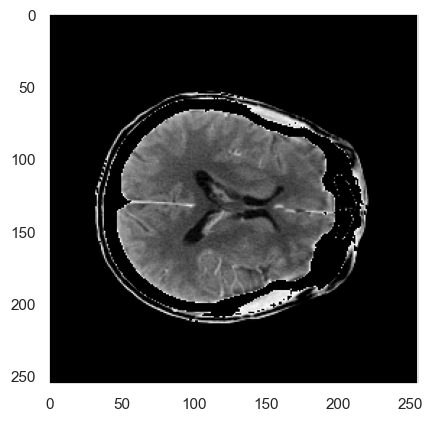

In [118]:
mask = ct_recolored
data[mask>=0.9] = 0
plt.imshow(data, 'gray')
plt.grid(False);

Alguns detalhes se perderam, mas a maior parte da imagem continua sendo reconhecida facilmente, mesmo usando um fator de compressão de 1 milhão. Apesar de ser uma aplicação bem interessante, existem melhores métodos de comprimir informações em imagens, mas o exemplo mostra o poder de se pensar fora da caixa com métodos não supervisionados.

# Modelo de mistura de Gaussianas ( _Gaussian Mixture Models (GMM)_ )


A simplicidade do $k$-Means leva a alguns desafios na prática. Em particular, sua natureza não probabilística e seu uso da abordagem 'distância até o centro do cluster mais próximo' pode levar a uma performance não tão boa em aplicações reais. Nesse sentido, vamos conhecer o GMM, que pode ser visto como uma extensão das ideias por trás do $k$-Means, mas que pode ir além do simples agrupamento.

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivação do GMM: fraquezas do $k$-Means

Como vimos, o $k$-Means funciona bem em dados bem separáveis, funcionando de forma rápida e eficiente:

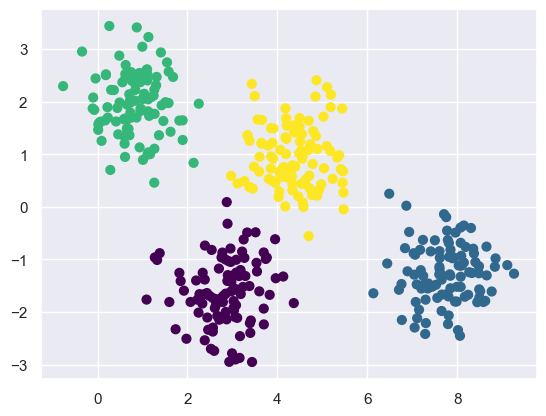

In [91]:
# Gerando alguns dados
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.6, random_state=0)
X = X[:, ::-1] # trocando os eixos para plotar melhor

# Plotando os dados com os indices do k-Means
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
plt.show()

Podemos observar que os rotulos atribuidos a algumas amostras são mais certos que outros: por exemplo, tem uma sobreposião bem pequena entre os 2 agrupamentos centrais, de modo que podemos não ter total certeza sobre os pontos entre elas. Infelizmente, $k$-Means não nos dá uma métrica de confiança na sua predição, como por exemplo uma probabilidade.

Um jeito de pensar no $k$-médias é como se ele traçasse um circulo (ou hiper-esfera para dimensionalidades mais altas) no centro de cada agrupamento, com o raio definido pela amostra mais distante do agrupamento. Esse raio representa o ponto de corte para a atribuição do rótulo do agrupamento: qualquer ponto fora desse círculo não é considerado um membro do agrupamento:

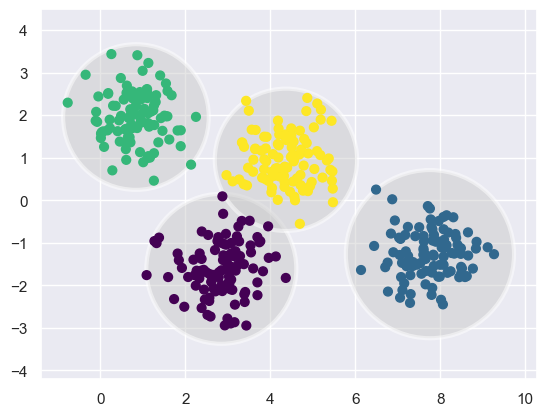

In [17]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.predict(X)
    #labels = kmeans.fit_predict(X)

    # plota os dados de entrada
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plota os circulos com as representações dos modelos
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        
        
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

Uma observação importante para o $k$-Means é que esses modelos de agrupamentos devem ser circulares: $k$-Means não consegue lidar bem com agrupamentos de forma alongada ou elíptica. Então, se por exemplo, os dados forem transformados para se adequarem a esses formatos, os agrupamentos acabam ficando confusos:

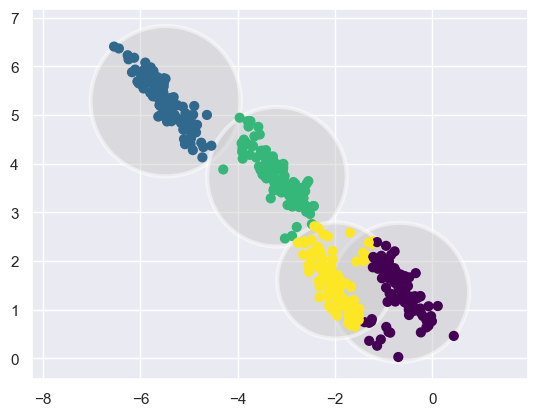

In [18]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

De olho, conseguimos identificar que esses agrupamentos não são circulares, logo modelos circulares (proporcionados pelo $k$-Means) não são a melhor opção para representá-los.

GMM tenta lidar com essas falhas do $k$-Means, i.e., falta de uma interpretação de pertinência ao agrupamento e tratando as bordas circulares, computando a distância até as amostras mais próximas, em vez do centro do agrupamento e usando bordas elípticas, em vez de circulares.

## Generalizando o EM: GMM

Um modelo que utiliza mistura de Gaussiandas tenta encontrar a mistura de distribuições de probabilidades Gaussianas multi-dimensionais que melhor modelam qualquer dado de entrada. No caso mais simples, GMMs podem ser usadas para encontrar os agrupamentos da mesma maneira que o $k$-médias.


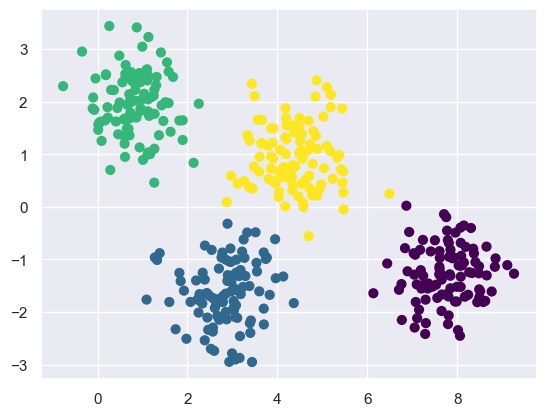

In [93]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
plt.show()

Mas como GMM é um modelo probabilístico, é possível encontrar a pertinência de cada amostra no agrupamento atribuído usando o método `predict_proba`. O método retorna uma matriz de tamanho [n_amostras, n_agrupamentos] que mede a probabilidade de um ponto pertencer a cada um dos agrupamentos:

In [94]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))
# p(x|theta)

[[0.463 0.    0.    0.537]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]]


Podemos visualizar essa incerteza, por exemplo, plotando o tamanho de cada ponto proporcional à certeza que temos de sua predição; Nesse contexto, as amostras nas bordas de cada agrupamento refletem essa incerteza:

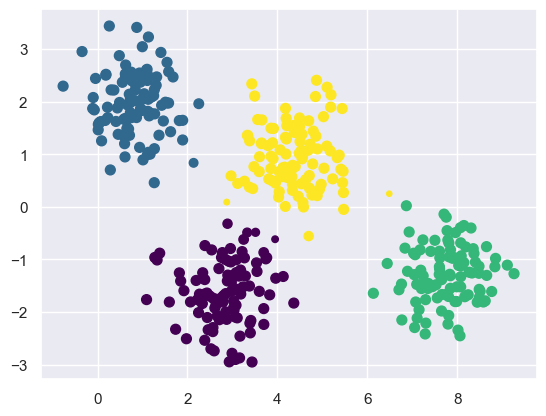

In [21]:
size = 50 * probs.max(1) ** 2  # ao quadrado para enfatizar a diferença
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size)
plt.show()

No geral, GMM é bem parecido com $k$-Means: usa EM, que como já vimos, mas com algumas diferênças:

1. Chuta alguns valores aleatórios como centro dos agrupamentos
2. Repete até convergir

    2.1. E-Step: para cada ponto, encontra os pesos representando a probabilidade de pertinencia em um agrupamento
    
    2.2. M-Step: para cada agrupamento, atualiza a sua localização, normalização, e formato, baseado em todos os pontos e seus pesos
 
O resultado é que cada agrupamento é associado não a uma esfera, mas com um modelo representado por uma Gaussiana suave. Assim como no $k$-Means, o EM pode não encontrar a solução ótima global.

Vamos criar uma função para visualizar esse comportamento:

In [22]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Desenha uma elipse com um ponto médio (position) e uma matriz de covariancia"""
    ax = ax or plt.gca()
    
    # Converte a covariancia para o eixo principal 
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Desenha a elipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.predict(X)
    #labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

Com essa função podemos observar o que o GMM nos dá como saída:

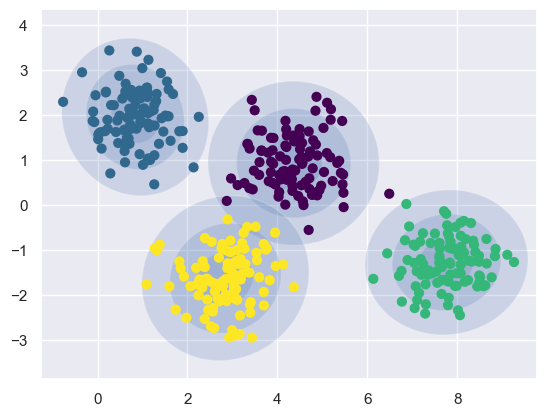

In [23]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

De forma similar, podemos usar o GMM para ajustar nosso dataset esticado. O modelo é capaz de ajustar até mesmo os agrupamentos esticados e alongados.

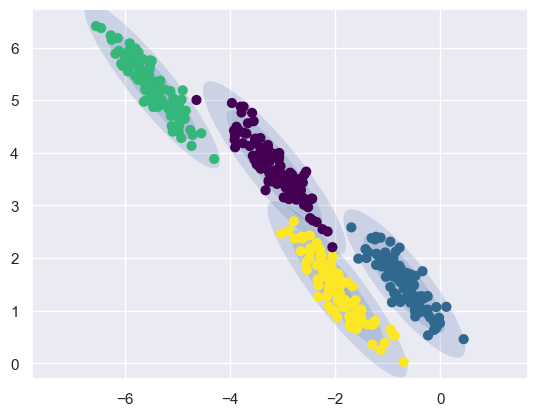

In [24]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

Isso deixa claro que o GMM resolve as 2 principais limitalções do $k$-Means.

## GMM como um estimador de densidade

Embora o GMM seja frequentemente categorizado como um algoritmo de agrupamento, ele é, fundamentalmente, um algoritmo para estimar densidades. Isso quer dizer que o resultado do ajuste do GMM a um conjunto de dados não é tecnicamente um model de agrupamento, mas um modelo generativo probabilistico que descreve a distribuição dos dados. 

Para ilustrar, considere alguns dados gerados com a função `make_moons`:

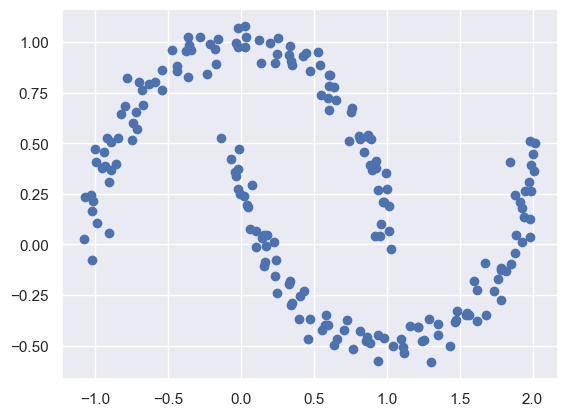

In [95]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])
plt.show()

Se tentarmos ajustar o GMM para encontrar 2 agrupamentos, o resultado pode não ser muito útil:

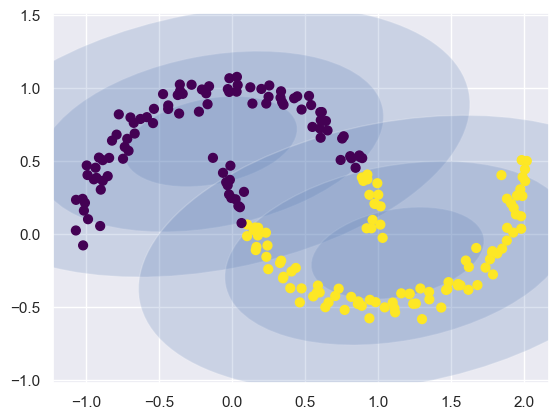

In [96]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

mas se em vez disse nós usarmos muito mais componentes (número de agrupamentos) e ignorar o rótulo atribuído pelo indice dos agrupamentos, encontramos um ajuste muito melhor aos dados de entrada:

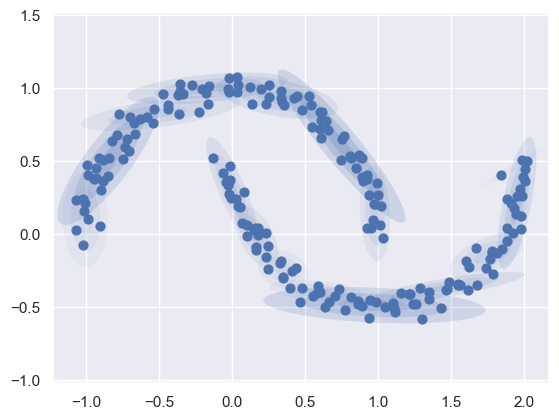

In [102]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Aqui a mistura de 16 Gaussianas serve não para encontrar agrupamentos separados nos dados, mas para modelar a distribuição geral dos dados de entrada. Esse passa a ser um modelo generativo da distribuição, o que significa que o GMM nos dá a receita para gerar novos dados aleatórios distribuídos de forma similar aos dados de entrada. Como exemplo, podemos gerar (fazer uma amostragem) 400 novos pontos a partir dos 16 componentes encontrados pelo GMM:


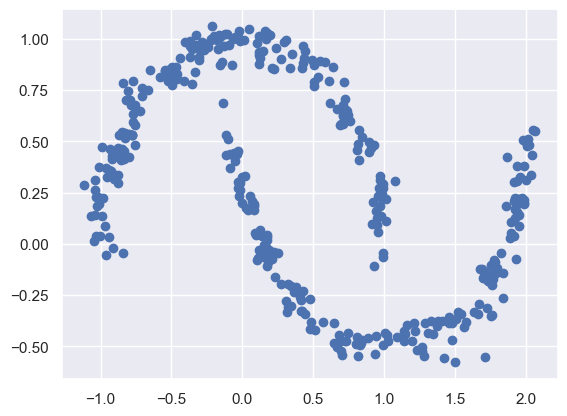

In [28]:
Xnew, _ = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1])
plt.show()

GMM oferece um meio conveniente e flexivel para modelar uma distribuição arbitrária de dados multi-dimensionais.

# Exercício

Usar GMM para aprender a distribuição de cada digito do dataset MNIST e gerar novas amostras a partir dessas distribuições

784

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

In [30]:
from sklearn.datasets import load_digits, fetch_openml

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
#X, y = load_digits(return_X_y=True)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
X_train.shape

(42000, 784)

In [54]:
gmm10 = GaussianMixture(n_components=30, covariance_type='full', random_state=0)
gmm10.fit(X_train)

GaussianMixture(n_components=30, random_state=0)

In [55]:
Xnew, _ = gmm10.sample(40)

In [56]:
Xnew[0].shape

(784,)

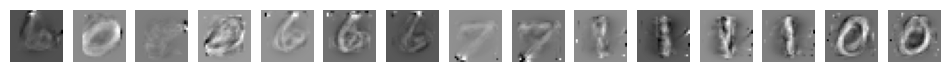

In [57]:
num_imagens = 15
fig, axs = plt.subplots(1, num_imagens, figsize=(12, 4))
for i in range(num_imagens):
    axs[i].imshow(Xnew[i].reshape((28, 28)), cmap="gray")
    axs[i].axis('off')
plt.show()

In [58]:
import pickle

with open('gmm30.pkl', 'wb') as files:
    pickle.dump(gmm10, files)